In [129]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from functools import reduce
from operator import add
import matplotlib.pyplot as plt
import seaborn

plt.style.use('fivethirtyeight')
%matplotlib inline


In [130]:
db = MongoClient().billboard

## Reading in Data

In [131]:
df1 = pd.DataFrame(map(lambda r: [r['metadata']['artists'][0]['name'],
                        r['metadata']['album']['id'],
                        r['metadata']['album']['album_type'],
                        r['metadata']['album']['total_tracks'],
                        r['metadata']['album']['release_date'],
                        r['metadata']['album']['release_date_precision'],
                        r['metadata']['disc_number'],
                        r['metadata']['duration_ms'],
                        r['metadata']['explicit'],
                        r['metadata']['id'],
                        r['metadata']['name'],
                        r['metadata']['popularity'],
                        r['metadata']['track_number'],
                        r['audio_features']['danceability'],
                        r['audio_features']['energy'],
                        r['audio_features']['acousticness'],
                        r['audio_features']['key'],
                        r['audio_features']['loudness'],
                        r['audio_features']['mode'],
                        r['audio_features']['speechiness'],
                        r['audio_features']['instrumentalness'],
                        r['audio_features']['liveness'],
                        r['audio_features']['valence'],
                        r['audio_features']['tempo'],
                        r['audio_features']['time_signature'],
                        r['_id']
                       ], db.spotify.find()), 
                  columns=
                       ['artist',
                        'album_id',
                        'album_type',
                        'total_tracks',
                        'release_date',
                        'release_date_precision',
                        'disc_number',
                        'duration_ms',
                        'explicit',
                        'track_id',
                        'title',
                        'popularity',
                        'track_number',
                        'danceability',
                        'energy',
                        'acousticness',
                        'key',
                        'loudness',
                        'mode',
                        'speechiness',
                        'instrumentalness',
                        'liveness',
                        'valence',
                        'tempo',
                        'time_signature',
                        'obj_id'
                       ])
df.shape

(13501, 34)

In [132]:
df2 = pd.DataFrame(map(lambda r: [r['metadata']['artists'][0]['name'],
                        r['metadata']['album']['id'],
                        r['metadata']['album']['album_type'],
                        r['metadata']['album']['total_tracks'],
                        r['metadata']['album']['release_date'],
                        r['metadata']['album']['release_date_precision'],
                        r['metadata']['disc_number'],
                        r['metadata']['duration_ms'],
                        r['metadata']['explicit'],
                        r['metadata']['id'],
                        r['metadata']['name'],
                        r['metadata']['popularity'],
                        r['metadata']['track_number'],
                        r['audio_features']['danceability'],
                        r['audio_features']['energy'],
                        r['audio_features']['acousticness'],
                        r['audio_features']['key'],
                        r['audio_features']['loudness'],
                        r['audio_features']['mode'],
                        r['audio_features']['speechiness'],
                        r['audio_features']['instrumentalness'],
                        r['audio_features']['liveness'],
                        r['audio_features']['valence'],
                        r['audio_features']['tempo'],
                        r['audio_features']['time_signature'],
                        None
                       ], db.spotify_nillboard.find()), 
                  columns=
                       ['artist',
                        'album_id',
                        'album_type',
                        'total_tracks',
                        'release_date',
                        'release_date_precision',
                        'disc_number',
                        'duration_ms',
                        'explicit',
                        'track_id',
                        'title',
                        'popularity',
                        'track_number',
                        'danceability',
                        'energy',
                        'acousticness',
                        'key',
                        'loudness',
                        'mode',
                        'speechiness',
                        'instrumentalness',
                        'liveness',
                        'valence',
                        'tempo',
                        'time_signature',
                        'obj_id'
                       ])
df2.shape

(42377, 26)

In [133]:
lyrics_df = pd.DataFrame(map(lambda r: [r['_id'],
                                        r['response_artist'],
                                        r['response_title'],
                                        r['dict_sentiment']['pos'],
                                        r['dict_sentiment']['neg'],
                                        r['dict_sentiment']['wordcount']], 
                            db.lyrics.find()), columns=
                                       ['track_id',
                                        'response_artist',
                                        'response_title',
                                        'poscount',
                                        'negcount',
                                        'wordcount'
                                       ])
lyrics_df.shape

(13461, 6)

In [134]:
np.sum((lyrics_df.poscount>0) | (lyrics_df.negcount>0) | (lyrics_df.wordcount>0))

13461

In [135]:
# UNTESTED
bbdf = pd.DataFrame(map(lambda r: [r['_id'],
                                  r['artist'],
                                  r['title'],
                                  r['date'],
                                  r['peakPos'],
                                  r['weeks']], 
                            db.hot100filtered.find()), columns=
                                 ['obj_id',
                                  'bb_artist',
                                  'bb_title',
                                  'date',
                                  'peakPos',
                                  'weeks'
                                 ])
bbdf.shape

(28550, 6)

In [136]:
#None of the genres are filled
adf = pd.DataFrame(map(lambda r: [r['_id'],
                                  r['label'],
                                  r['popularity']],
                            db.spotify_albums.find()), columns=
                                 ['album_id',
                                  'label',
                                  'album_popularity',
                                 ])
adf.shape

(4050, 3)

## Combining Data

In [137]:
df = df1.append(df2, ignore_index=True, sort=False)\
        .merge(right=lyrics_df, how='outer', on='track_id')\
        .merge(right=adf, how='left', on='album_id')
df.shape

(49761, 33)

## EDA

### Transforms

In [138]:
df['on_billboard'] = ~df.obj_id.isna()
df.release_date = pd.to_datetime(df.release_date, format='%Y-%m-%d')
df['norm_sentiment'] = (df.poscount-df.negcount)/(df.poscount+df.negcount+1)
df['rel_sentiment'] =(df.poscount-df.negcount)/(df.wordcount)
df['release_year'] = df.release_date.apply(lambda dt:dt.year)
df['release_month'] = df.apply(lambda r:r.release_date.month if r.release_date_precision=='day' else np.nan, axis=1)

### Drop columns after merging


In [139]:
df.drop(columns=['track_id', 'obj_id', 'poscount', 'negcount'], inplace=True)
haslyrics = ~df.response_title.isna()
df = df[haslyrics]

### Todo:
1. categorical handling for mode, time sig, key, album type?
2. match spotify to genius by trackname and artist
3. breakout month and year?


In [26]:
labels = np.array(reduce(add, df.label.apply(lambda s:s.split('/'))))
labels = np.array(list(map(lambda s: s.strip().lower(), labels)))
np.unique(labels).shape

(942,)

In [ ]:
for l in np.unique(labels):
    print(l)

In [46]:
df.columns

Index(['artist', 'album_id', 'album_type', 'total_tracks', 'release_date',
       'release_date_precision', 'disc_number', 'duration_ms', 'explicit',
       'title', 'popularity', 'track_number', 'danceability', 'energy',
       'acousticness', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'response_artist', 'response_title', 'wordcount', 'label',
       'album_popularity', 'on_billboard', 'norm_sentiment', 'rel_sentiment'],
      dtype='object')

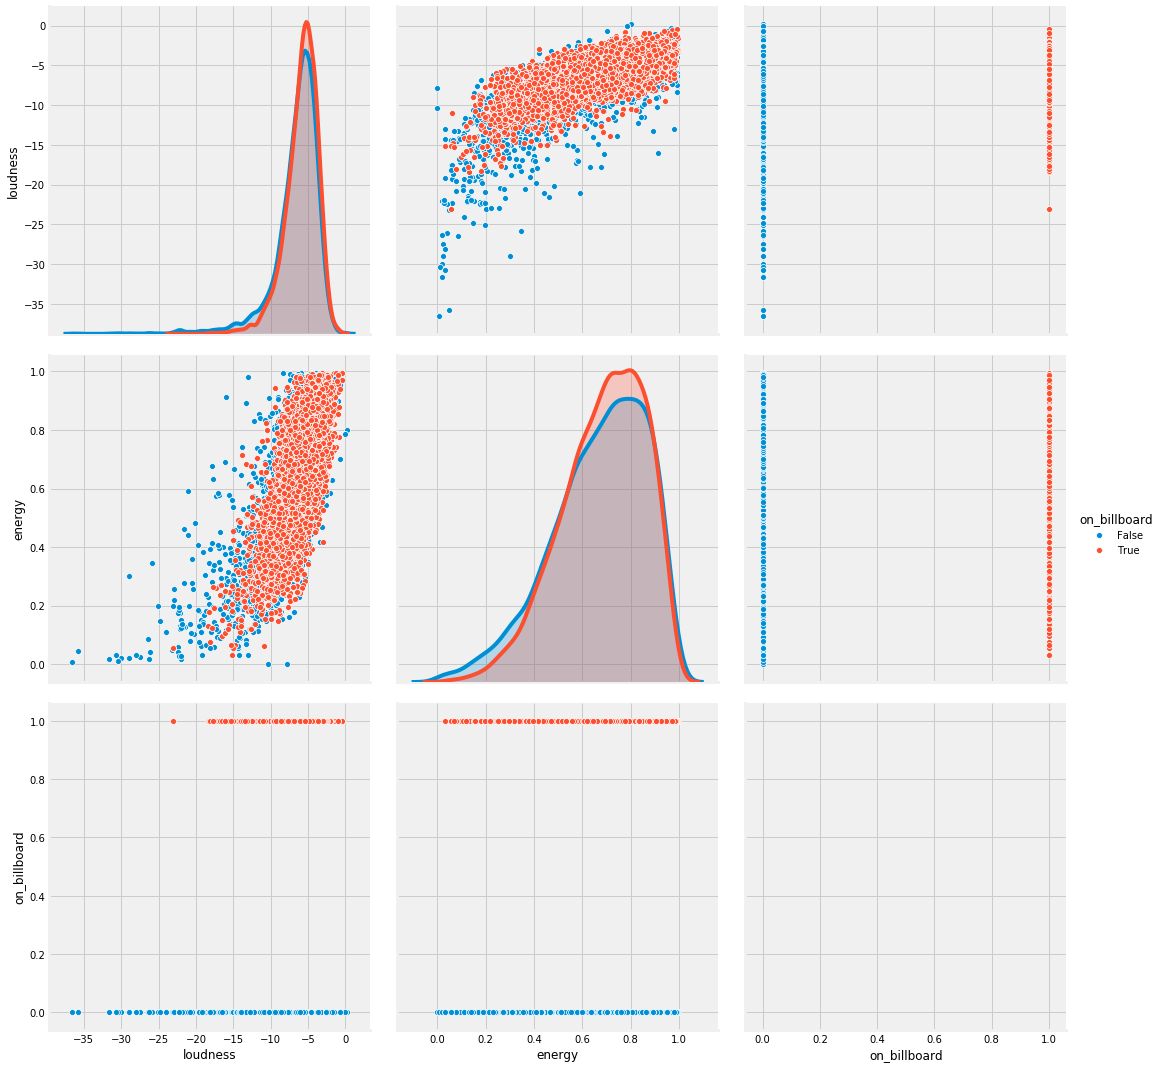

In [48]:
seaborn.pairplot(df[['loudness', 'energy', 'on_billboard']], hue='on_billboard', height=5)

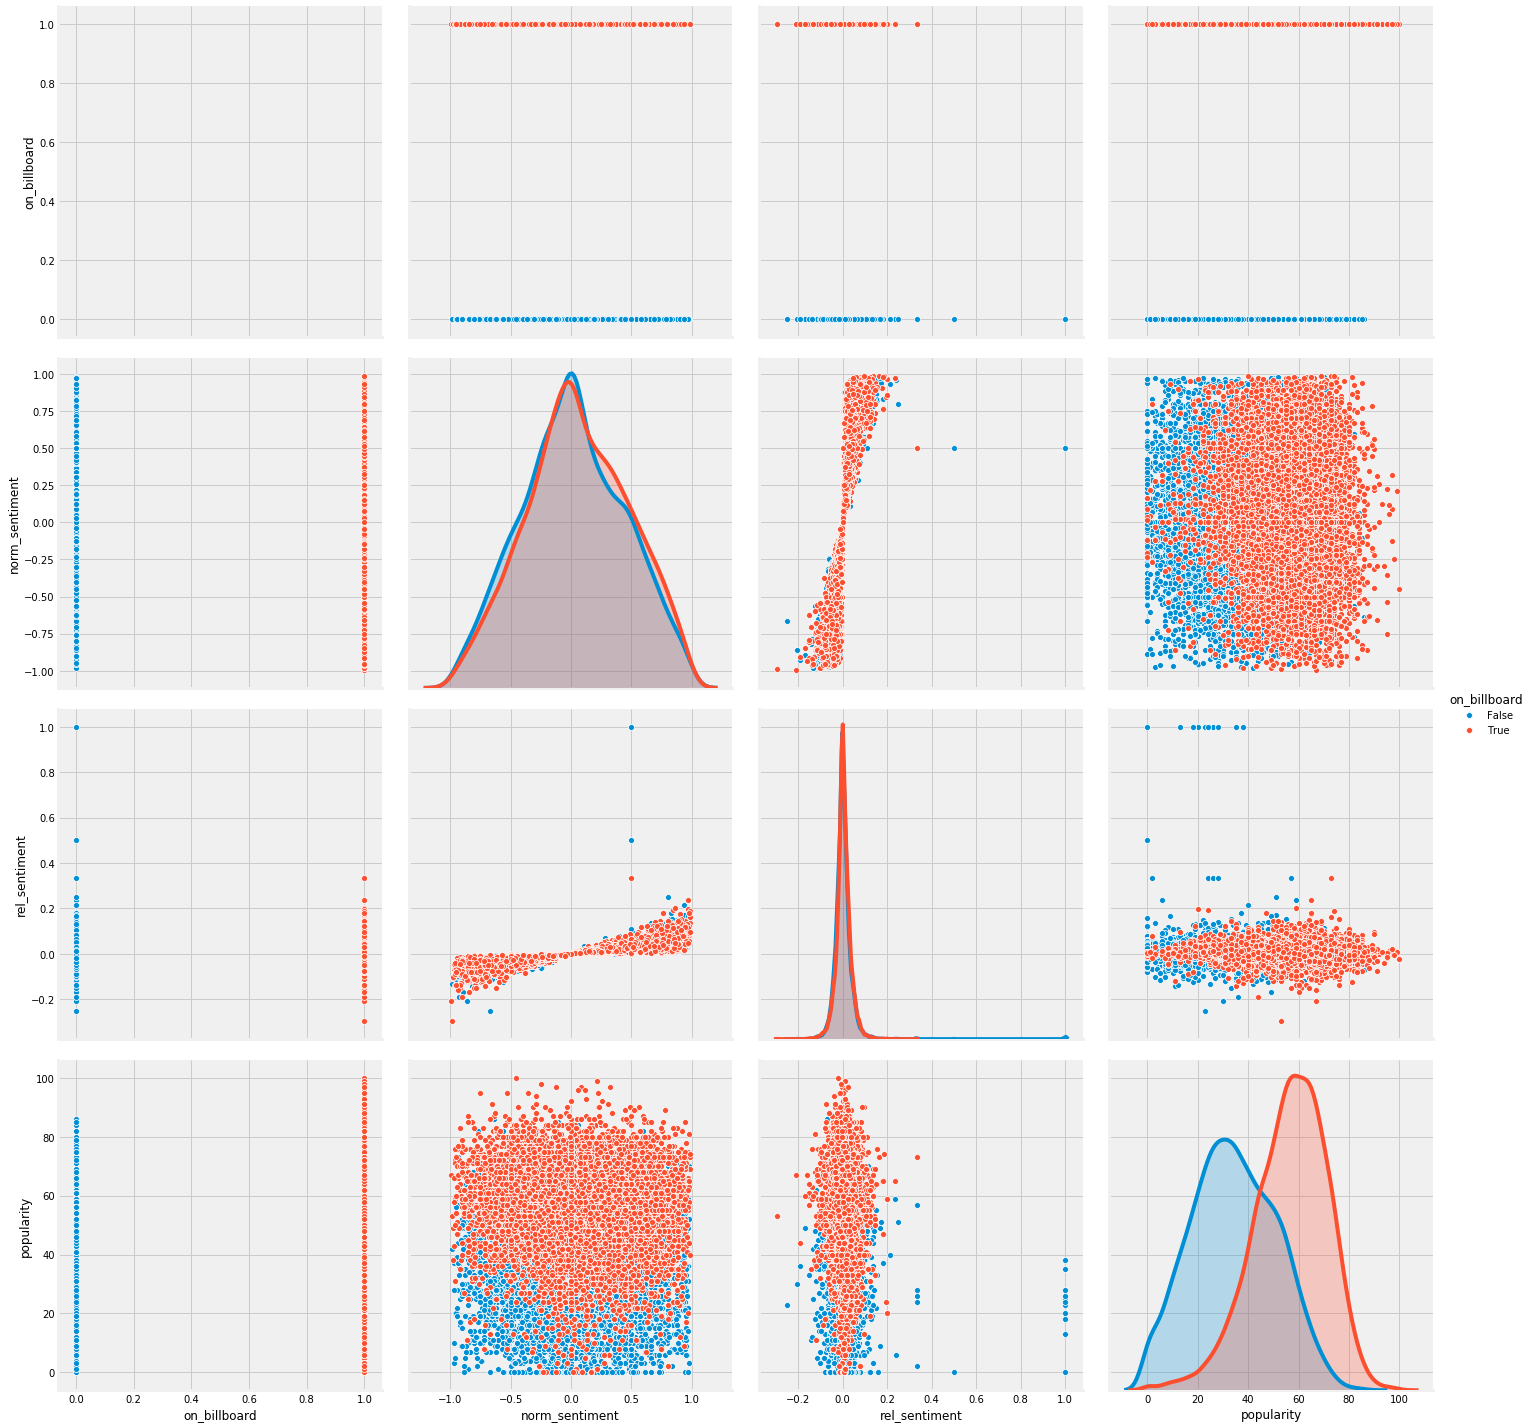

In [49]:
seaborn.pairplot(df[['on_billboard', 'norm_sentiment', 'rel_sentiment', 'popularity']], hue='on_billboard', height=5)

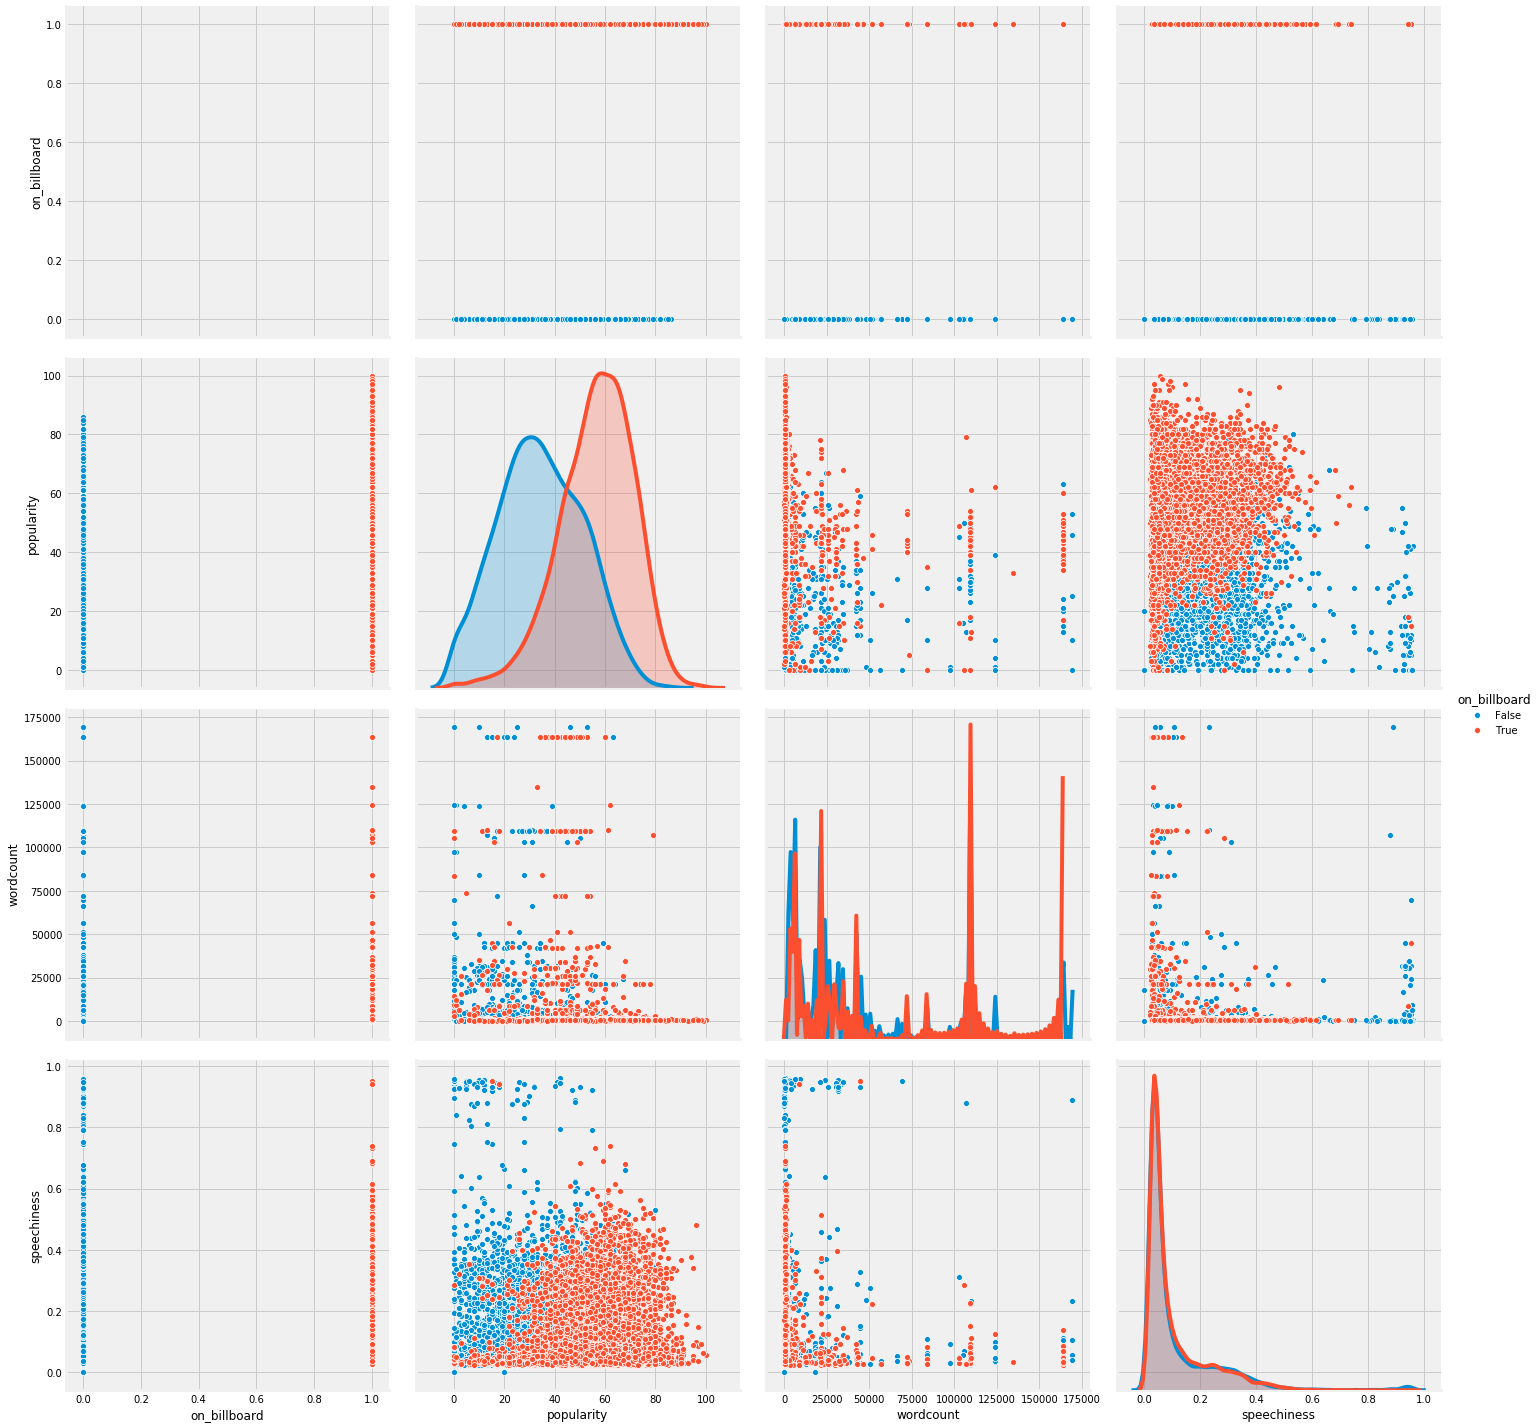

In [50]:
seaborn.pairplot(df[['on_billboard', 'popularity', 'wordcount', 'speechiness']], hue='on_billboard', height=5)

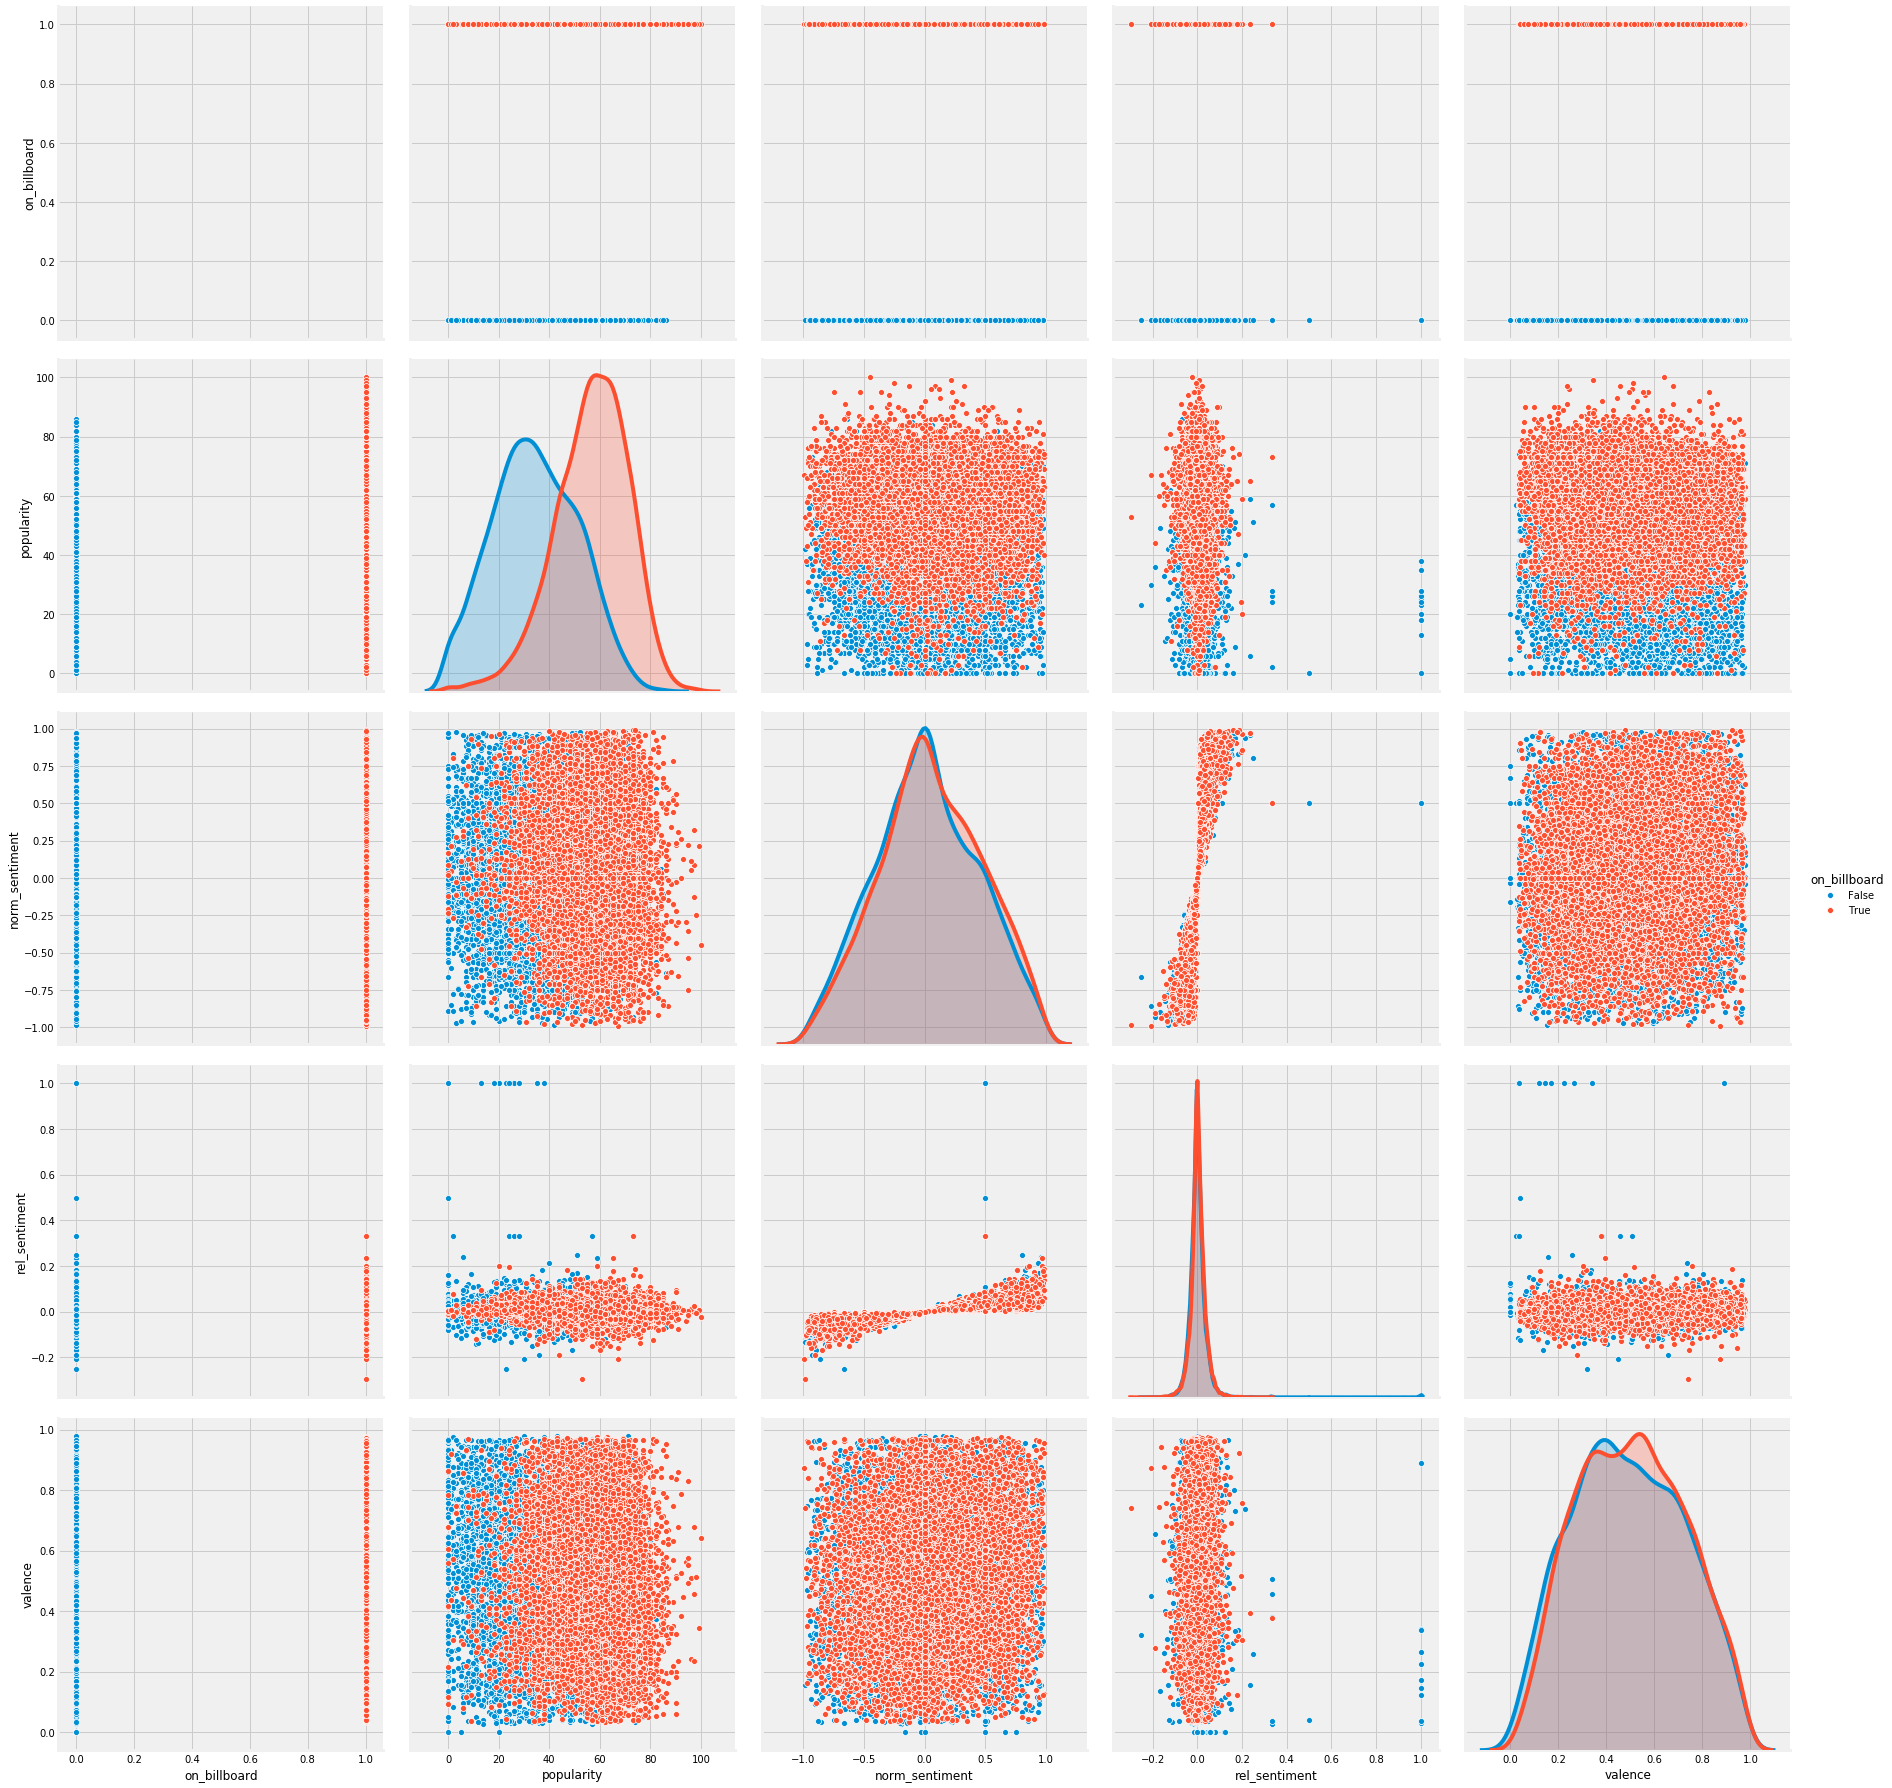

In [51]:
seaborn.pairplot(df[['on_billboard', 'popularity', 'norm_sentiment', 'rel_sentiment', 'valence']], hue='on_billboard', height=5)

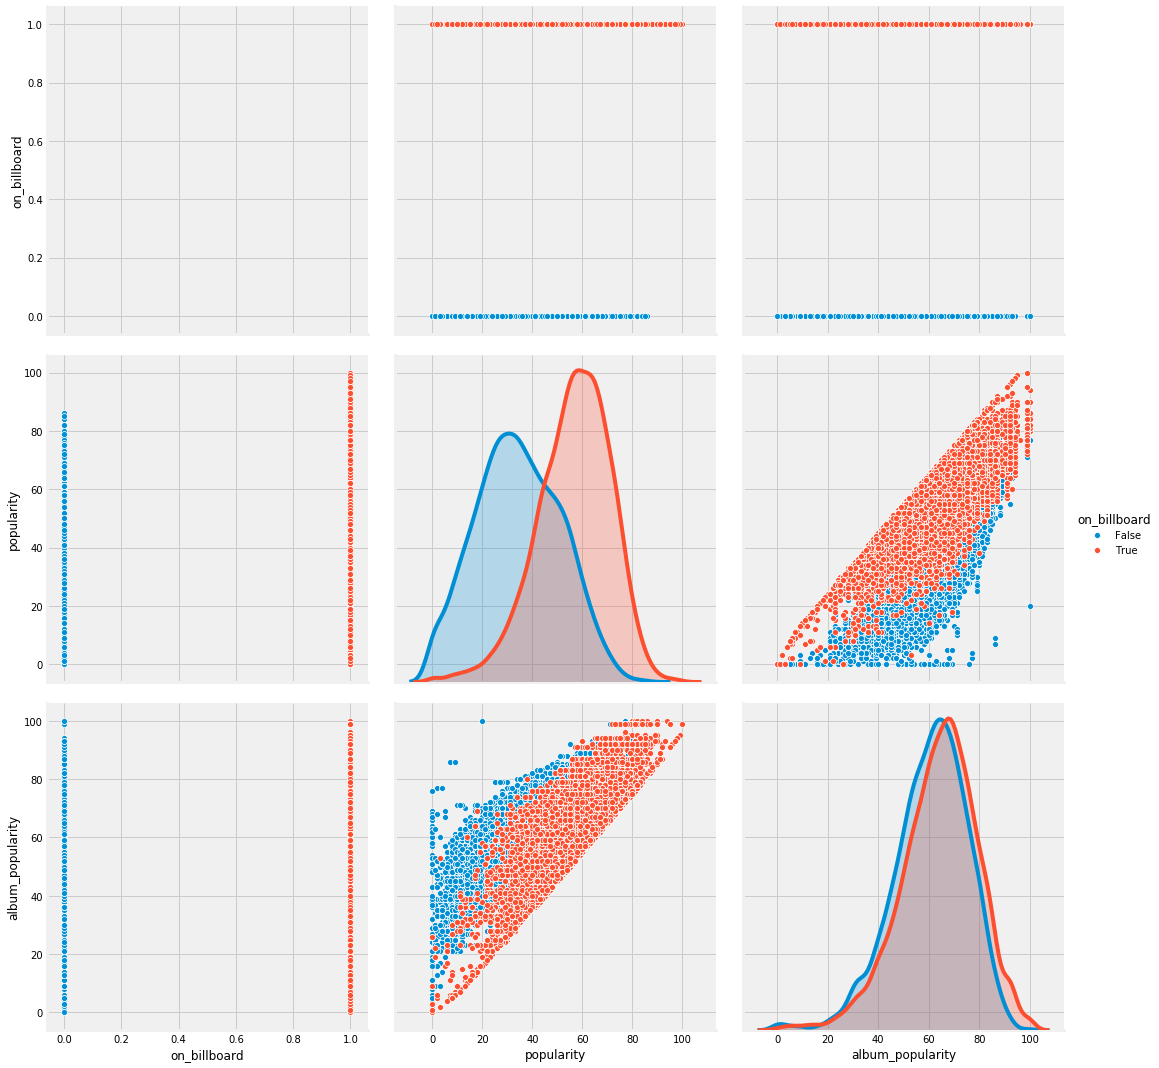

In [52]:
seaborn.pairplot(df[['on_billboard', 'popularity', 'album_popularity']], hue='on_billboard', height=5)

In [54]:
np.sum(df.release_date_precision=='year')

799

In [55]:
np.sum(df.release_date_precision=='day')

12702

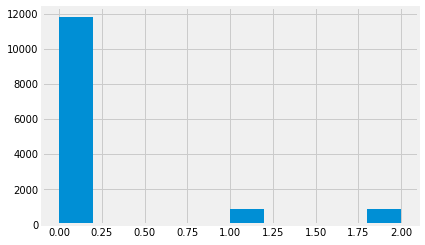

In [127]:
df.album_type.apply(lambda t:{'album':0, 'single':1, 'compilation':2}[t]).hist()

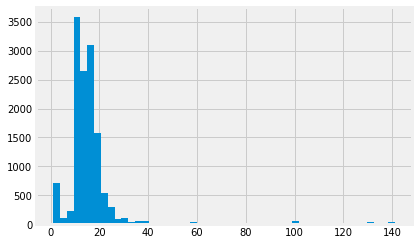

In [85]:
df.total_tracks.hist(bins=50)

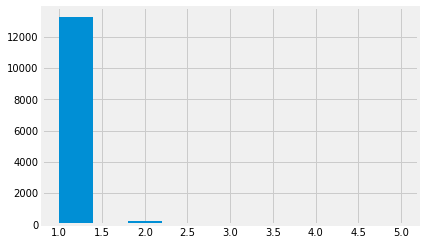

In [86]:
df.disc_number.hist()

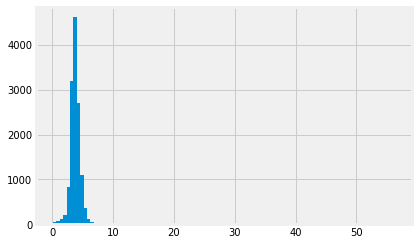

In [88]:
((df.duration_ms)/60000).hist(bins=100)

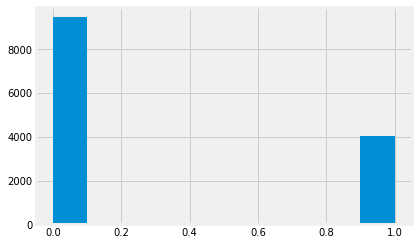

In [90]:
df.explicit.astype(int).hist()

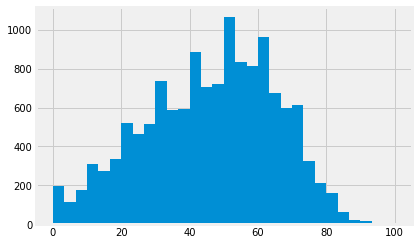

In [93]:
df.popularity.hist(bins=30)

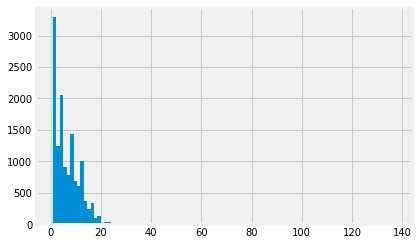

In [94]:
df.track_number.hist(bins=100)

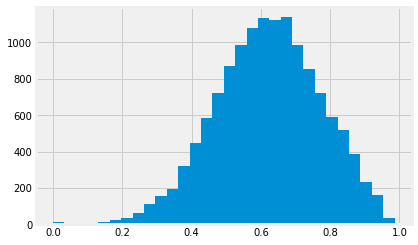

In [96]:
df.danceability.hist(bins=30)

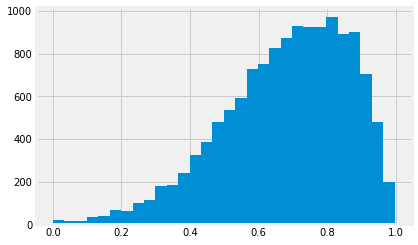

In [97]:
df.energy.hist(bins=30)

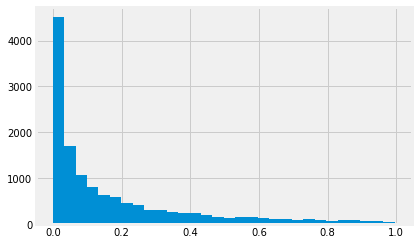

In [98]:
df.acousticness.hist(bins=30)

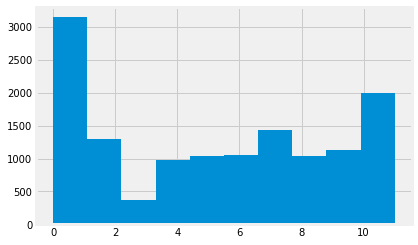

In [99]:
df.key.hist()

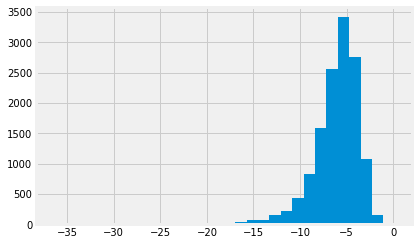

In [101]:
df.loudness.hist(bins=30)

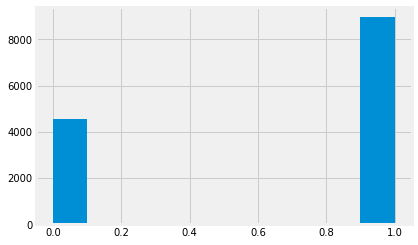

In [103]:
df['mode'].hist()

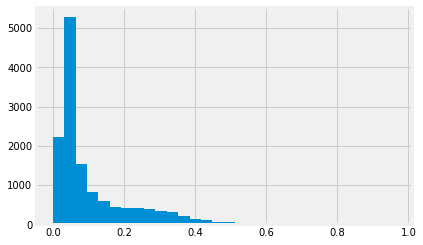

In [104]:
df.speechiness.hist(bins=30)

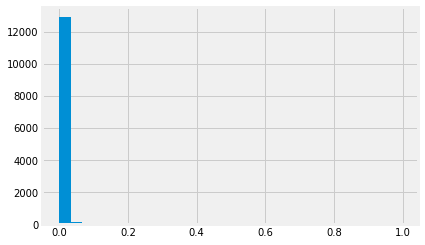

In [107]:
df.instrumentalness.hist(bins=30)

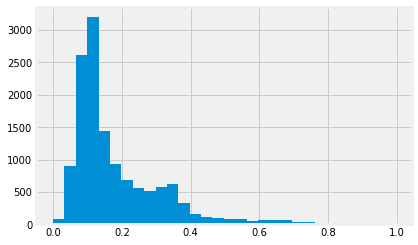

In [108]:
df.liveness.hist(bins=30)

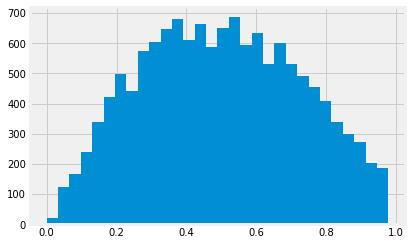

In [109]:
df.valence.hist(bins=30)

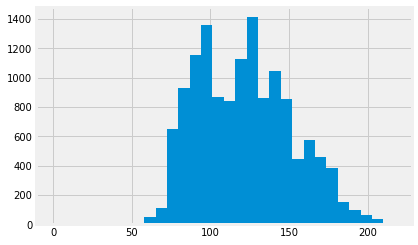

In [110]:
df.tempo.hist(bins=30)

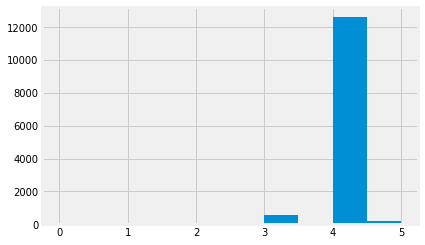

In [111]:
df.time_signature.hist()

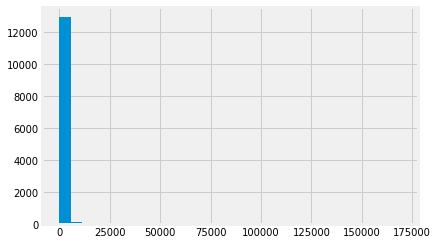

In [112]:
df.wordcount.hist(bins=30)

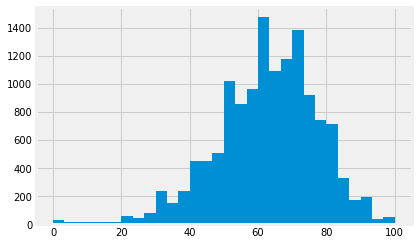

In [115]:
df.album_popularity.hist(bins=30)

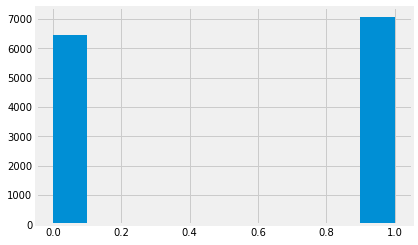

In [116]:
df.on_billboard.astype(int).hist()

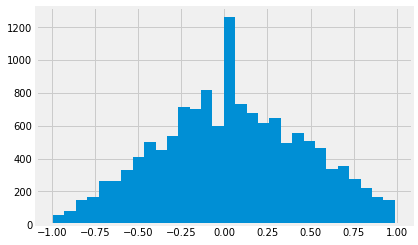

In [118]:
df.norm_sentiment.hist(bins=30)

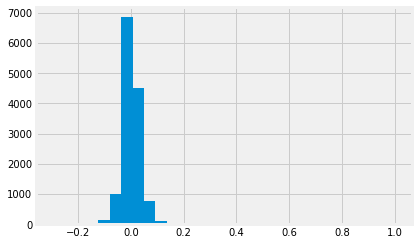

In [121]:
(df.rel_sentiment).hist(bins=30)

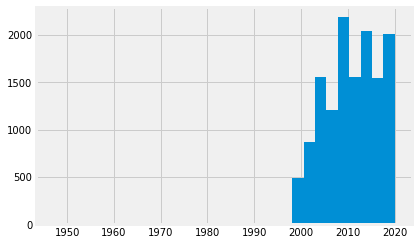

In [122]:
df.release_year.hist(bins=30)

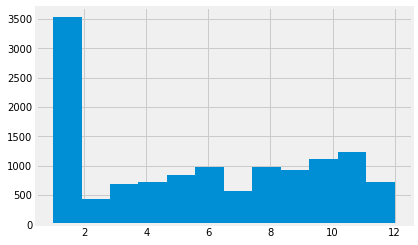

In [125]:
df.release_month.hist(bins=12)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13501 entries, 2 to 49759
Data columns (total 34 columns):
artist                    13501 non-null object
album_id                  13501 non-null object
album_type                13501 non-null object
total_tracks              13501 non-null int64
release_date              13501 non-null datetime64[ns]
release_date_precision    13501 non-null object
disc_number               13501 non-null int64
duration_ms               13501 non-null int64
explicit                  13501 non-null bool
title                     13501 non-null object
popularity                13501 non-null int64
track_number              13501 non-null int64
danceability              13501 non-null float64
energy                    13501 non-null float64
acousticness              13501 non-null float64
key                       13501 non-null int64
loudness                  13501 non-null float64
mode                      13501 non-null int64
speechiness             